<a href="https://colab.research.google.com/github/RevazRevazashvili/geo-hate-speech-analysis/blob/main/notebooks/tfidf_logreg_classifier_with_lime_explanations_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook contains the code for training georgian hate speech classifier based on youtube and facebook comments data that is labeled manually.

This second version of notebook includes additional data and synthetic dataset generation techniques to improve the model performance

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from wordcloud import WordCloud
import sys
import sklearn

# Load Georgian Hate Speech Dataset

In [2]:
!wget https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/combined-data/combined-labeled-data.csv

--2023-12-06 10:44:02--  https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/combined-data/combined-labeled-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285785 (279K) [text/plain]
Saving to: ‘combined-labeled-data.csv’

combined-labeled-da 100%[===================>] 279.09K  --.-KB/s    in 0.006s  

2023-12-06 10:44:02 (42.4 MB/s) - ‘combined-labeled-data.csv’ saved [285785/285785]



In [5]:
!wget https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/youtube-crawl/youtube-good-data-edited.csv

--2023-12-06 10:49:39--  https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/youtube-crawl/youtube-good-data-edited.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 479322 (468K) [text/plain]
Saving to: ‘youtube-good-data-edited.csv’

youtube-good-data-e 100%[===================>] 468.09K  --.-KB/s    in 0.007s  

2023-12-06 10:49:39 (68.4 MB/s) - ‘youtube-good-data-edited.csv’ saved [479322/479322]



In [8]:
!wget https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/bizeri-data/bizeri-data.csv

--2023-12-06 10:51:30--  https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/bizeri-data/bizeri-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7094441 (6.8M) [text/plain]
Saving to: ‘bizeri-data.csv’

bizeri-data.csv     100%[===================>]   6.77M  --.-KB/s    in 0.03s   

2023-12-06 10:51:30 (226 MB/s) - ‘bizeri-data.csv’ saved [7094441/7094441]



In [3]:
raw_data = pd.read_csv("combined-labeled-data.csv")

In [6]:
youtube_good_comments = pd.read_csv("youtube-good-data-edited.csv")

In [9]:
bidzer = pd.read_csv("bizeri-data.csv")

## Explore Samples

In [4]:
raw_data.head()

,hate,female,filtered_text
0,1.0,0.0,ჩაიგდე ხმა შე მავნებელი ომი საქართველომ დაიწყო...
1,1.0,1.0,სამარცხვინო ქალო მიდი გაეკიდე ქაცარავას
2,0.0,0.0,იმოწმედეთ პრეზიდენტო
3,1.0,1.0,რა უზნეო ქალი ხარ არ იცი როგორ აურიო ქვეყანა გ...
4,1.0,0.0,Neta icodet mainc ras bjuturobt


In [7]:
youtube_good_comments.head()

,0
0,ეროვნულ ჰიმნზე ლამის გული ამომვარდეს პატრიოტიზ...
1,სხვისი შვილი
2,წარმატებები ლაშა
3,ეხლა გინდ შაიტანეთ გინდ გამაიტანეთ თქვენი რუმბ...
4,ლაშა მაგარი ხარ


In [10]:
bidzer.head()

,word,explanation,use_case
0,მოშჩხო,როცა ძმაკაცები UFC -ს იხსენებენ და ერთ-ერთს შე...,მიდიოდა და იმენა მოშჩხო
1,უილ დიზის ყლე კარგად გამოიყურება შენს პირში,როცა ფოტოს გამოგიზავნის ტიპი და ჰკითხავ ვინ არ...,-გამარჯობა ზუკა\r\n-გამარჯობა ლევან\r\n-გინდა ...
2,ბებია,ყლე რომელიც ყიდის უფასოდ ტკბილეულს,ბებია ყლეა
3,"წამეცადინება, წავიმეცადინებ","""წათამაშების"" ბიძაშვილი სიტყვა, რომელიც გამოიყ...","- სანამ საჭმელი გაცხელდება წავალ, ცოტას წავიმე..."
4,სუყლე,"გამოიყენება ისეთი ადამიანის აღსაწერად, რომელიც...","- შეჩემა, სუყლე როგორ არის?\r\n- ვინაა სუყლე?\..."


# Preprocess Data

## Combined Labeled Data

### Explore

Explore samples with missing labels

In [11]:
print(f"{round(raw_data.hate.isna().sum()/raw_data.shape[0] * 100.0, 2)}% missing labels")

0.0% missing labels


We only have Hate speech labels. The rest is assumed to be non-hate speech labels so we relabel data here

In [12]:
raw_data.hate.dropna().value_counts()

0.0    1449
1.0     674
Name: hate, dtype: int64

In [13]:
raw_data.hate.fillna(0).value_counts(normalize=True)

0.0    0.682525
1.0    0.317475
Name: hate, dtype: float64

explore empty texts

In [14]:
(raw_data['filtered_text'].apply(lambda x: len(x) if isinstance(x, str) else 0) == 0).sum()

0

In [15]:
raw_data['female'].value_counts()

0.0    1958
1.0     163
Name: female, dtype: int64

### Extract Dataset Features

In [16]:
dataset = raw_data[['hate', 'filtered_text']]

In [17]:
dataset.head()

,hate,filtered_text
0,1.0,ჩაიგდე ხმა შე მავნებელი ომი საქართველომ დაიწყო...
1,1.0,სამარცხვინო ქალო მიდი გაეკიდე ქაცარავას
2,0.0,იმოწმედეთ პრეზიდენტო
3,1.0,რა უზნეო ქალი ხარ არ იცი როგორ აურიო ქვეყანა გ...
4,1.0,Neta icodet mainc ras bjuturobt


In [18]:
dataset.columns = ['label', 'text']

In [19]:
dataset = dataset[dataset['text'].apply(lambda x: len(x) if isinstance(x, str) else 0) > 0]

In [20]:
dataset.label.fillna(0, inplace=True)

In [21]:
dataset.label.value_counts(normalize=True)

0.0    0.682525
1.0    0.317475
Name: label, dtype: float64

Perform transliteration of georgian texts written with english letters

In [22]:
def transliterate_to_georgian(text):
    transliteration_dict = {
        'a': 'ა',
        'b': 'ბ',
        'g': 'გ',
        'd': 'დ',
        'e': 'ე',
        'v': 'ვ',
        'z': 'ზ',
        't': 'თ',
        'i': 'ი',
        'k': 'კ',
        'l': 'ლ',
        'm': 'მ',
        'n': 'ნ',
        'o': 'ო',
        'p': 'პ',
        'zh': 'ჟ',
        'r': 'რ',
        's': 'ს',
        'T': 'ტ',
        'u': 'უ',
        'f': 'ფ',
        'q': 'ქ',
        'gh': 'ღ',
        'y': 'ყ',
        'sh': 'შ',
        'ch': 'ჩ',
        'ts': 'ც',
        'c': 'ც',
        'dz': 'ძ',
        'ts': 'წ',
        'w': 'წ',
        'ch': 'ჭ',
        'kh': 'ხ',
        'x': 'ხ',
        'j': 'ჯ',
        'h': 'ჰ',
    }

    georgian_text = ''
    if text is not None and isinstance(text, str):
        for char in text.lower():
            if char in transliteration_dict:
                georgian_text += transliteration_dict[char]
            else:
                georgian_text += char

    return georgian_text

In [23]:
dataset['text'] = dataset['text'].apply(transliterate_to_georgian)

In [24]:
dataset.loc[2057, 'text']

'მადლობა კრისტი რო ესეთ ვიდეოებს იღებ ჩემი შვილი რო მეტყვის მამა ყლე რა არისო ამას ვაჩვანებ'

In [25]:
dataset.sample(20)

,label,text
185,1.0,შენნაირი მოღალატეები არ არიან ამ ქვეყნის ღირსი...
965,0.0,ღარიბაშვილი
89,1.0,ყლექალა
379,0.0,წარმატებები
804,0.0,დიდებული პრემიერი წარმატებები საქრთველოს
1439,0.0,საამაყო პრემიერი
62,1.0,ლიკა რევაზისჰვილი ატრაკუნებ
324,1.0,ეკათერინე კაცჰლისჰვილი ნაბიჭვარო არაქალო ნიკოზ...
1387,0.0,წარმატებები
350,0.0,წარმატებები პრემიერს


## Youtube Good Comments Only

### Explore

In [33]:
youtube_good_comments.columns = ['text']

explore random samples

In [34]:
youtube_good_comments.sample(5, random_state=1)

,text
1916,განუმეორებელო ვაჟკაცო ნათელში იყავისულ
2445,NaN
3253,NaN
3794,giorgi modixar
1791,NaN


explore empty texts

In [35]:
(youtube_good_comments['text'].apply(lambda x: len(x) if isinstance(x, str) else 0) == 0).sum()

1392

### Extract Dataset Features

In [36]:
youtube_good_comments = youtube_good_comments[
    youtube_good_comments['text'].apply(lambda x: len(x) if isinstance(x, str) else 0) > 0
]

In [37]:
youtube_good_comments['label'] = 0.0

<ipython-input-37-e40917991a69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_good_comments['label'] = 0.0


In [38]:
youtube_good_comments.label.value_counts(normalize=True)

0.0    1.0
Name: label, dtype: float64

Perform transliteration of georgian texts written with english letters

In [39]:
def transliterate_to_georgian(text):
    transliteration_dict = {
        'a': 'ა',
        'b': 'ბ',
        'g': 'გ',
        'd': 'დ',
        'e': 'ე',
        'v': 'ვ',
        'z': 'ზ',
        't': 'თ',
        'i': 'ი',
        'k': 'კ',
        'l': 'ლ',
        'm': 'მ',
        'n': 'ნ',
        'o': 'ო',
        'p': 'პ',
        'zh': 'ჟ',
        'r': 'რ',
        's': 'ს',
        'T': 'ტ',
        'u': 'უ',
        'f': 'ფ',
        'q': 'ქ',
        'gh': 'ღ',
        'y': 'ყ',
        'sh': 'შ',
        'ch': 'ჩ',
        'ts': 'ც',
        'c': 'ც',
        'dz': 'ძ',
        'ts': 'წ',
        'w': 'წ',
        'ch': 'ჭ',
        'kh': 'ხ',
        'x': 'ხ',
        'j': 'ჯ',
        'h': 'ჰ',
    }

    georgian_text = ''
    if text is not None and isinstance(text, str):
        for char in text.lower():
            if char in transliteration_dict:
                georgian_text += transliteration_dict[char]
            else:
                georgian_text += char

    return georgian_text

In [40]:
youtube_good_comments['text'] = youtube_good_comments['text'].apply(transliterate_to_georgian)

<ipython-input-40-c6d48e53629e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_good_comments['text'] = youtube_good_comments['text'].apply(transliterate_to_georgian)


In [50]:
youtube_good_comments.shape

(4156, 2)

## Bidzer Bad Words

### Explore

In [47]:
bidzer.head()

,word,explanation,use_case
0,მოშჩხო,როცა ძმაკაცები UFC -ს იხსენებენ და ერთ-ერთს შე...,მიდიოდა და იმენა მოშჩხო
1,უილ დიზის ყლე კარგად გამოიყურება შენს პირში,როცა ფოტოს გამოგიზავნის ტიპი და ჰკითხავ ვინ არ...,-გამარჯობა ზუკა\r\n-გამარჯობა ლევან\r\n-გინდა ...
2,ბებია,ყლე რომელიც ყიდის უფასოდ ტკბილეულს,ბებია ყლეა
3,"წამეცადინება, წავიმეცადინებ","""წათამაშების"" ბიძაშვილი სიტყვა, რომელიც გამოიყ...","- სანამ საჭმელი გაცხელდება წავალ, ცოტას წავიმე..."
4,სუყლე,"გამოიყენება ისეთი ადამიანის აღსაწერად, რომელიც...","- შეჩემა, სუყლე როგორ არის?\r\n- ვინაა სუყლე?\..."


In [49]:
bidzer.shape

(13975, 3)

explore random samples

In [48]:
bidzer.sample(5, random_state=1)

,word,explanation,use_case
11445,ცალკარა,ქართული ფეხბურთის შესანიშნავი შესატყვისი ბოლო ...,ქართველიი გულშემატკივარი: ცალკარაა მა დედამოტყ...
1966,სხვა რას შვები?,"როდესაც ნაცნობმა ადამიანმა კითხვა -""როგორ ხარზ...","-ვაა... გუმბაზ, შე ჩათლახო, სად დაგვეკარგე ტოო..."
6982,ამთავებელი,ადამიანი რომელიც გმირულად ცდილბს წრეშიბურთის თ...,-ბიჭებიდან ვინ ათავებთ?\r\n-სად? რას?
2210,ჭანტურია,ეს კაცი/ქალი საიმედო არაა,შენ ჭანტურია არ გამოხვიდე თორე ვერ გაგიძლებ
12744,ბებერო,მამაკაცი მეგობრისადმი თბილი და გულთადი მიმართვა,როგორ ხარ ბებერო? სად დაიკარგე ბებერო?


explore empty texts

In [51]:
(bidzer['use_case'].apply(lambda x: len(x) if isinstance(x, str) else 0) == 0).sum()

1

remove samples where english explanations present

In [63]:
bidzer_latin_char_perc = bidzer['use_case'].apply(lambda x: sum([c in "qwertyuiopasdfghjklzxcvbnm" for c in x])/len(x)*100.0)

In [64]:
(bidzer_latin_char_perc > 0).sum()

283

In [66]:
bidzer[bidzer_latin_char_perc > 0].head(5)

,word,explanation,use_case
61,duke,პრო ჰაკერი რომელმაც დაჰაკა პენტაგონი,dukem dahaka pentagoni
67,ვოტპადის მომხმარებელი,უიმედო რომანტიკოსი ვინც თავის თავში სხვადასხვა...,-Tatia rasshveba sadaaaa\r\n-kide otaxshia cha...
72,Lrg,ელარჯი,Lrg დავცხოთ
79,https://m.youtube.com/watch?v=dQw4w9WgXcQ,https://m.youtube.com/watch?v=dQw4w9WgXcQ,https://m.youtube.com/watch?v=dQw4w9WgXcQ
83,ჰაკერი bash,"ჰაკერი სახელად bash არის 10წლის, რომელმაც აღმო...",ჰაკერი bash-ის საყვარელი წინადადებაა no system...


not too many of them. Will remove all

In [69]:
bidzer[~(bidzer_latin_char_perc > 0)].shape

(13691, 3)

In [70]:
bidzer = bidzer[~(bidzer_latin_char_perc > 0)]

### Extract Dataset Features

In [71]:
bidzer_data = bidzer[
    bidzer['use_case'].apply(lambda x: len(x) if isinstance(x, str) else 0) > 0
]

In [72]:
bidzer_data.shape

(13691, 3)

IMPORTANT_NOTE!

It seems that `word` features aren't always bad words separately. We want to use those sentences or phrases to contaminate good youtube comments and generate synthetic dataset where bad words in text means hate speech. I will use `use_case` feature values as bad phrases and add them into good texts.

In [73]:
bidzer_data.head(3)

,word,explanation,use_case
0,მოშჩხო,როცა ძმაკაცები UFC -ს იხსენებენ და ერთ-ერთს შე...,მიდიოდა და იმენა მოშჩხო
1,უილ დიზის ყლე კარგად გამოიყურება შენს პირში,როცა ფოტოს გამოგიზავნის ტიპი და ჰკითხავ ვინ არ...,-გამარჯობა ზუკა\r\n-გამარჯობა ლევან\r\n-გინდა ...
2,ბებია,ყლე რომელიც ყიდის უფასოდ ტკბილეულს,ბებია ყლეა


In [74]:
bidzer_data['label'] = 1.0

In [75]:
bidzer_data.label.value_counts(normalize=True)

1.0    1.0
Name: label, dtype: float64

# Generate Full Dataset

## Label Distributions

In [80]:
dataset.label.value_counts(normalize=True), dataset.label.value_counts(normalize=False)

(0.0    0.682525
 1.0    0.317475
 Name: label, dtype: float64,
 0.0    1449
 1.0     674
 Name: label, dtype: int64)

## Generate Synthetic Dataset Using Youtube Good Comments

- take youtube good comments as `non-hate` class examples
- take 50% of them and add random bidzer texts to them to create `hate` class examples
- take half of the youtube data count randomly from disjoint subset of bidzer samples also as `hate` class

In [107]:
first_half_of_bidzer_texts = bidzer_data.sample(frac=1, random_state=1).head(bidzer_data.shape[0] // 2)['use_case']
second_half_of_bidzer_texts = bidzer_data.sample(frac=1, random_state=1).tail(bidzer_data.shape[0] // 2)['use_case']

In [114]:
import random
def _create_hate_speec_text(text):
  if random.random() > 0.5:
    return first_half_of_bidzer_texts.sample(1).iloc[0]
  else:
    return text + " " + second_half_of_bidzer_texts.sample(1).iloc[0]

In [119]:
synthetic_dataset = pd.concat(
    [
        youtube_good_comments.iloc[:,:].reset_index(drop=True)[['text', 'label']],
        pd.DataFrame(
            {
                "text": youtube_good_comments['text'].apply(_create_hate_speec_text).tolist(),
                "label": youtube_good_comments['text'].apply(lambda x: 1.0)
            }
        )
    ]
)

In [120]:
synthetic_dataset

,text,label
0,ეროვნულ ჰიმნზე ლამის გული ამომვარდეს პატრიოტიზ...,0.0
1,სხვისი შვილი,0.0
2,წარმატებები ლაშა,0.0
3,ეხლა გინდ შაიტანეთ გინდ გამაიტანეთ თქვენი რუმბ...,0.0
4,ლაშა მაგარი ხარ,0.0
...,...,...
5543,-ნახე გიომ რა მაგარ ადგილას დაიწყო მუშაობა\r\n...,1.0
5544,.,1.0
5545,"ყ წამო , წამო სექტორში მწიფე ფუჩურები დავკრიფოთ",1.0
5546,ეს ჭურჭელკ სულ დასარეცხია ფაჩიკოს გარმონივით,1.0


# Train Classifier

# Train Classifier

In [121]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=be870a96a310766132904f0c399f18e92a4edc4913dff2db87624035e2308915
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

### Without Synthetic Data

In [123]:
# Define the TF-IDF vectorizer with a vocabulary size of 10,000 and n-grams of 1-3
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(2, 10), analyzer="char_wb")

# Define the PCA dimensionality reduction with a suitable number of components
svd = TruncatedSVD(n_components=100)  # Adjust the number of components as needed

# Define the logistic regression classifier
logistic_regression = LogisticRegression()

# Create the pipeline with TF-IDF, PCA, and Logistic Regression
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('svd', svd),
    ('classifier', logistic_regression)
])

# Assuming you have your data in X and labels in y
X = dataset['text']
y = dataset['label']

# Split the data into an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Perform 3-fold cross-validation with F1 score evaluation metrics
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')

# Print the F1 scores for each fold
for fold, f1 in enumerate(f1_scores):
    print(f'Fold {fold + 1} F1 Score: {f1}')

# Train the classifier on the entire training set and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1_test = f1_score(y_test, y_pred)

print(f'Test F1 Score: {f1_test}')

Fold 1 F1 Score: 0.8963730569948186
Fold 2 F1 Score: 0.9095890410958904
Fold 3 F1 Score: 0.9304812834224598
Test F1 Score: 0.9103942652329748


Show vocab samples:

In [124]:
list(pipeline.steps[0][1].vocabulary_.keys())[:30]

[' წ',
 'წა',
 'არ',
 'რმ',
 'მა',
 'ატ',
 'ტე',
 'ებ',
 'ბე',
 'ბი',
 'ი ',
 ' წა',
 'წარ',
 'არმ',
 'რმა',
 'მატ',
 'ატე',
 'ტებ',
 'ებე',
 'ბებ',
 'ები',
 'ბი ',
 ' წარ',
 'წარმ',
 'არმა',
 'რმატ',
 'მატე',
 'ატებ',
 'ტებე',
 'ებებ']

### With Synthetic Data

Let's see if synthetic data improves the performance on manually labeled test set

In [191]:
# Define the TF-IDF vectorizer with a vocabulary size of 10,000 and n-grams of 1-3
tfidf_vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(2, 20), analyzer="char_wb")

# Define the PCA dimensionality reduction with a suitable number of components
svd = TruncatedSVD(n_components=2000)  # Adjust the number of components as needed

# Define the logistic regression classifier
logistic_regression = LogisticRegression()

# Create the pipeline with TF-IDF, PCA, and Logistic Regression
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('svd', svd),
    ('classifier', logistic_regression)
])

# Assuming you have your data in X and labels in y
X = dataset['text']
y = dataset['label']


# Split the data into an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add synthetic dataset
_synthetic_dataset_sample = synthetic_dataset.sample(n=len(X_train), random_state=1)
X_train = pd.concat([X_train, _synthetic_dataset_sample['text']]).reset_index(drop=True)
y_train = pd.concat([y_train, _synthetic_dataset_sample['label']]).reset_index(drop=True)

# Perform 3-fold cross-validation with F1 score evaluation metrics
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')

# Print the F1 scores for each fold
for fold, f1 in enumerate(f1_scores):
    print(f'Fold {fold + 1} F1 Score: {f1}')

# Train the classifier on the entire training set and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1_test = f1_score(y_test, y_pred)

print(f'Test F1 Score: {f1_test}')

Fold 1 F1 Score: 0.8702127659574469
Fold 2 F1 Score: 0.8661087866108788
Fold 3 F1 Score: 0.8715313463514903
Test F1 Score: 0.8978102189781023


Show some model mistakes on test set

In [193]:
pd.DataFrame({"text":X_test, "label": y_test})[y_pred != y_test]

,text,label
289,უტიფარი,1.0
1773,კლეს ათრევთ თკუილად,1.0
1075,წაკლა ჭურნალისტი წოწონავა,1.0
1728,საქართველო იმაზე მეტად ძვირფასი და ღირებულია ვ...,0.0
1882,ცრემლიანი თვალი თათუ ნისჰნავს კაცი გკავს მოკლული,1.0
869,ცოცხალი დემოკრატია კი არა ცოცხალი ხორცი უნდა ხ...,0.0
705,თუ გინდათ ჩვენი მიღება მიგვიღეთ რას გვეთამაშებით,0.0
290,დურაკო სჰენ,1.0
69,ასე მდაბიო როგორ ყოფილხარ,1.0
727,გაყარეთ მანდედან ევროპა სავსეა რუსებით და რატო...,0.0


# LIME explanations

In [194]:
def get_influential_words(comment, pipeline, num_features=10):
    # Create a LIME explainer
    explainer = LimeTextExplainer(
        kernel_width=25,
        kernel=None,
        verbose=True,
        class_names=['non-hate', 'hate'],
        feature_selection='auto',
        split_expression='\W+',
        bow=True,
        mask_string=None,
        random_state=42,
        char_level=False
    )

    # Define a function to predict using your classifier
    predict_fn = lambda x: pipeline.predict_proba(x)

    # Explain the prediction for the given comment
    explanation = explainer.explain_instance(comment, predict_fn, num_features=num_features)

    # Get influential words and their importance scores
    influential_words = explanation.as_list()

    return influential_words

In [195]:
def generate_visual_explanation(comment, pipeline, num_features=10):

    # get influential words using Lime Explainer
    influential_words = get_influential_words(comment, pipeline, num_features)

    # Create a heatmap-like visualization
    weights = [x[1] for x in influential_words]
    words = [x[0] for x in influential_words]
    colors = plt.cm.RdBu(np.array(weights) / max(weights))  # Normalize weights for color mapping

    plt.figure(figsize=(12, 6))
    plt.barh(words, weights, color=colors)
    plt.xlabel('Word Importance')
    plt.title('Influential Words in Comment')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

In [196]:
hate_sample = dataset.loc[2057, 'text']
hate_sample

'მადლობა კრისტი რო ესეთ ვიდეოებს იღებ ჩემი შვილი რო მეტყვის მამა ყლე რა არისო ამას ვაჩვანებ'

In [197]:
non_hate_sample = dataset.loc[980, 'text']
non_hate_sample

'როგორ დერსკად ელაპარაჯება საგორ'

In [198]:
get_influential_words(hate_sample, pipeline, 10)

Intercept 0.584312511960142
Prediction_local [0.8627098]
Right: 0.8479034838816203


[('ყლე', 0.12083357172747296),
 ('მადლობა', -0.09477183129479548),
 ('კრისტი', 0.08977394902529313),
 ('რა', 0.045993378928495636),
 ('შვილი', 0.03791041709944839),
 ('რო', 0.03560650686533965),
 ('მეტყვის', 0.022541018160958177),
 ('ვაჩვანებ', 0.02027698998975081),
 ('ამას', 0.016986766898066538),
 ('ესეთ', -0.016753483476526863)]

In [199]:
get_influential_words(non_hate_sample, pipeline, 10)

Intercept 0.31134969511469857
Prediction_local [0.35360781]
Right: 0.34495801709286245


[('ელაპარაჯება', 0.1338798792904016),
 ('საგორ', -0.05967104583073256),
 ('როგორ', -0.05785076187345153),
 ('დერსკად', 0.02590004127631346)]

Intercept 0.5736500752888019
Prediction_local [0.86740898]
Right: 0.8479034838816203


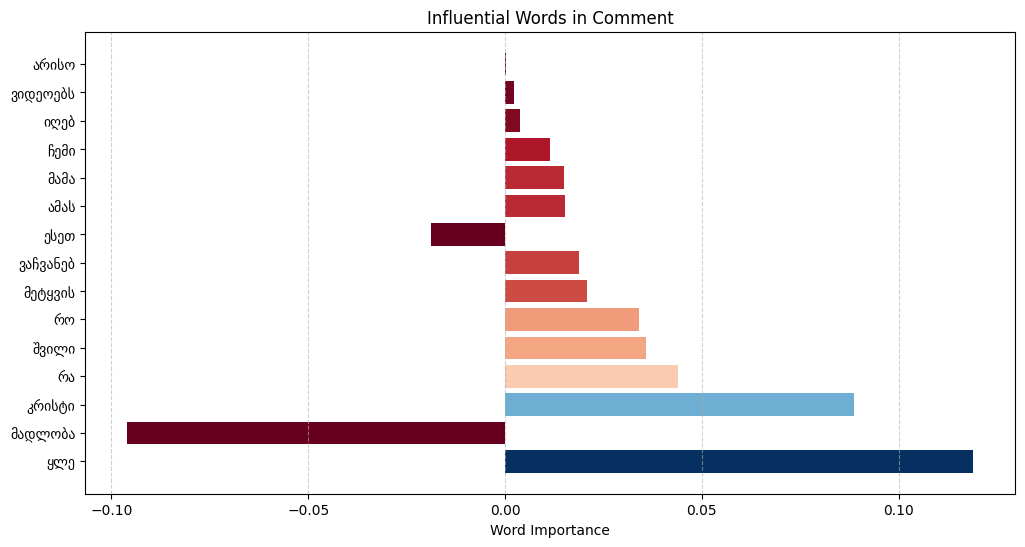

In [200]:
generate_visual_explanation(hate_sample, pipeline, 20)

Intercept 0.31134969511469857
Prediction_local [0.35360781]
Right: 0.34495801709286245


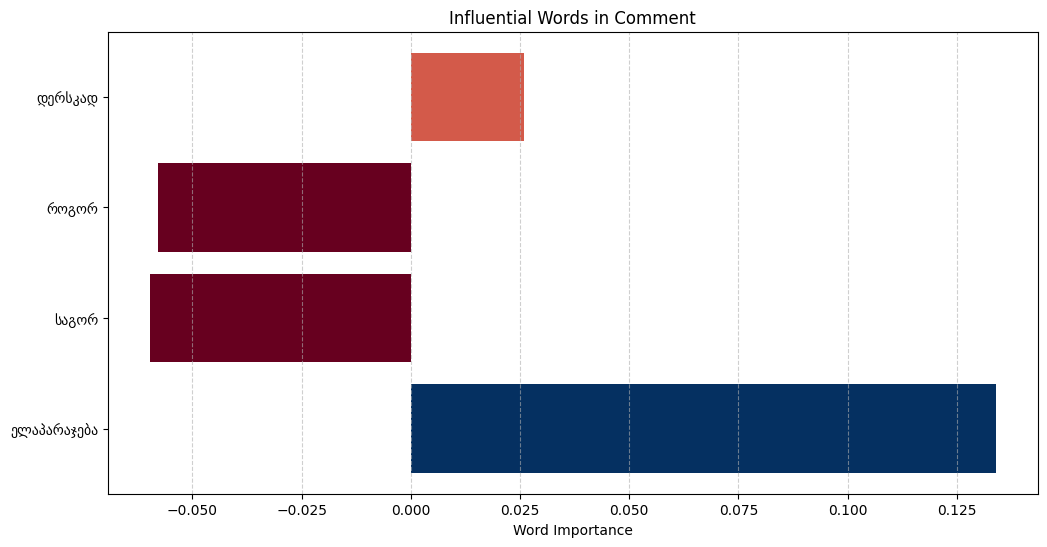

In [201]:
generate_visual_explanation(non_hate_sample, pipeline, 20)

# See Test Set Inference Results

In [202]:
test_inference_results_df = pd.DataFrame(
    {
        "text": X_test.values,
        "label": y_test.values,
        "predicted_label": pipeline.predict(X_test),
        "hate_prob": pipeline.predict_proba(X_test)[:, 1],
        "non_hate_prob": pipeline.predict_proba(X_test)[:, 0]
    }
)

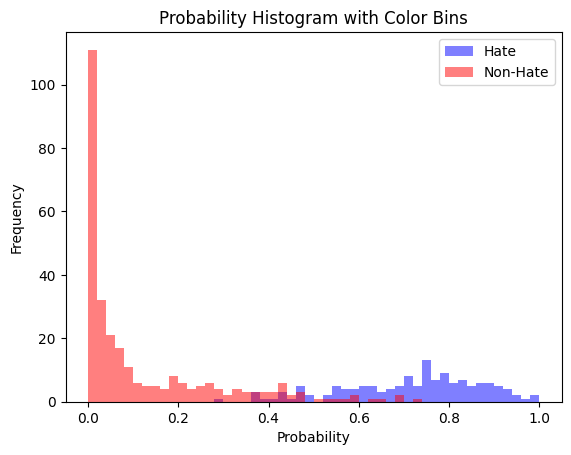

In [203]:
# Create a figure and axis
fig, ax = plt.subplots()

# Set the number of bins and range for the histogram
n_bins = 50
bin_range = (0, 1)

# Plot histograms for positive and negative class probabilities with different colors
ax.hist(
    test_inference_results_df['hate_prob'][test_inference_results_df.label == 1],
    bins=n_bins, range=bin_range, color='b', alpha=0.5, label='Hate')
ax.hist(
    test_inference_results_df['hate_prob'][test_inference_results_df.label == 0],
    bins=n_bins, range=bin_range, color='r', alpha=0.5, label='Non-Hate')

# Customize the plot
ax.set_xlabel('Probability')
ax.set_ylabel('Frequency')
ax.set_title('Probability Histogram with Color Bins')
ax.legend()

# Show the histogram
plt.show()

We can create some interval where model prediction isn't precise and questionable. For example, if we look at the hate class probability then
- non_hate: [0, 0.35]
- inconfident: [0.35, 0.7]
- hate: [0.7, 1.0]

In [204]:
test_inference_results_df.apply(lambda x: x['label'] == x['predicted_label'], axis=1).value_counts(normalize=True)

True     0.934118
False    0.065882
dtype: float64

In [205]:
test_inference_results_df.head(10)

,text,label,predicted_label,hate_prob,non_hate_prob
0,ცარმათებები ბ ირაკლი,0.0,0.0,0.024710,0.975290
1,ხო იდზახის სჰემხვდი და იქ მომთხოვე ახსნაო ვითო...,1.0,1.0,0.966385,0.033615
2,წარმატებები ბატონო პრემიერო,0.0,0.0,0.002444,0.997556
3,წარმატებები უჭკვიანეს და სამშობლოს მოყვარულ პრ...,0.0,0.0,0.050622,0.949378
4,ცარმათება ცჰვენს კვეყანას,0.0,0.0,0.159088,0.840912
5,წარმატებები,0.0,0.0,0.005580,0.994420
6,წარმატებები,0.0,0.0,0.005580,0.994420
7,ქრისთი სჰე ყლეო ყლიფონა ბოზანდარა ბიცჰი ხარ და...,1.0,1.0,0.895742,0.104258
8,კარგი ხარ ირაკლი,0.0,0.0,0.047645,0.952355
9,საამაყო პრემიერი,0.0,0.0,0.036282,0.963718


## Random Hate Speech Examples In Test Data

Intercept 0.8106769242062329
Prediction_local [0.98561416]
Right: 0.966385421367353


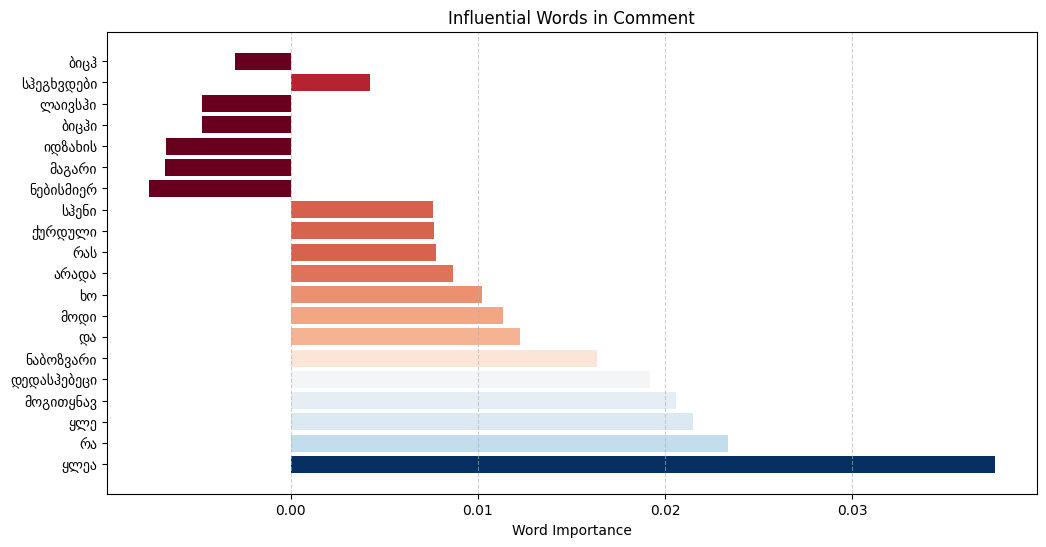

('ხო იდზახის სჰემხვდი და იქ მომთხოვე ახსნაო ვითომ ხო დზველ ბიცჰობს არადა მაგარი ნაბოზვარი როჯაა ჯერ რა ყლეა თიპს ზვეზდოცჰკა ნაკოლკა და ქურდული ნისჰნები ახათია თიპი იმ დონის ყლეა რო ლაივსჰი სჰემოდის თან თითველი ეს ყლე და დალსჰე რას იდზახის რა ოფ ქოურს რა ბიცჰ მოდი ნებისმიერ დროს სჰეგხვდები და მოგითყნავ მაგ ნაკოლკებს ვითოთ დზველი ბიცჰი დედასჰებეცი სჰენი',
 None)

In [206]:
test_inference_results_df.iloc[1]['text'], generate_visual_explanation(test_inference_results_df.iloc[1]['text'], pipeline, 20)

Intercept 0.6329452236052806
Prediction_local [0.92046115]
Right: 0.8957415553830094


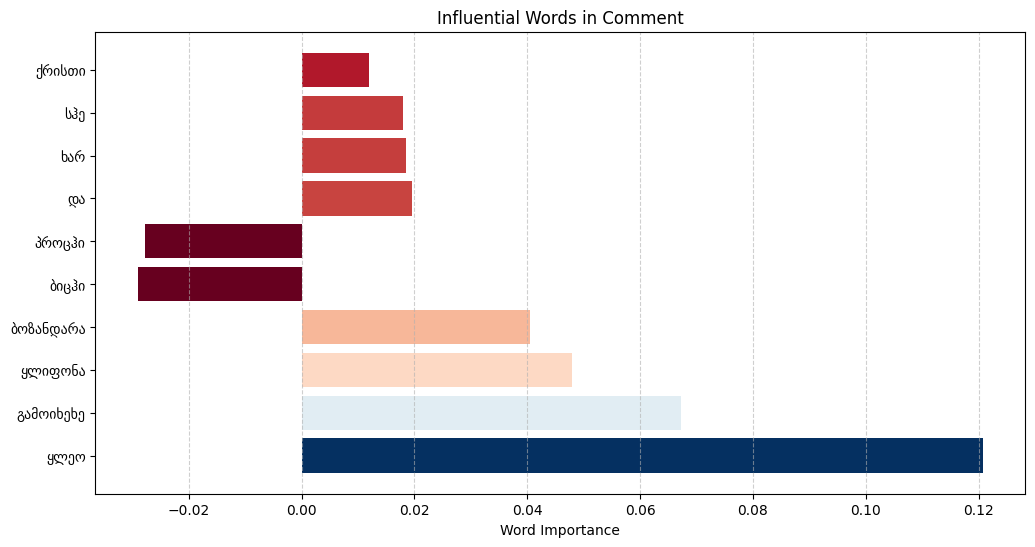

('ქრისთი სჰე ყლეო ყლიფონა ბოზანდარა ბიცჰი ხარ და გამოიხეხე პროცჰი', None)

In [207]:
test_inference_results_df.iloc[7]['text'], generate_visual_explanation(test_inference_results_df.iloc[7]['text'], pipeline, 20)

Intercept 0.2480984147146479
Prediction_local [0.02865097]
Right: 0.05062193775675989


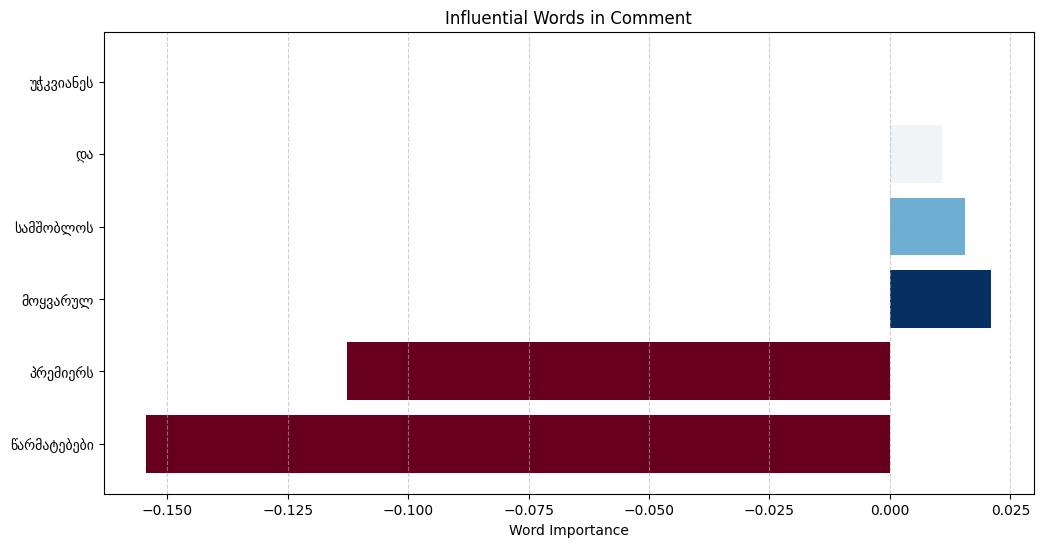

('წარმატებები უჭკვიანეს და სამშობლოს მოყვარულ პრემიერს', None)

In [208]:
test_inference_results_df.iloc[3]['text'], generate_visual_explanation(test_inference_results_df.iloc[3]['text'], pipeline, 20)

## Comments About President

In [209]:
test_inference_results_df[test_inference_results_df.text.apply(lambda x: 'პრეზი' in x)]

,text,label,predicted_label,hate_prob,non_hate_prob
65,ეს არაქალი მარტო პრეზიდენტობიდან კიარა ქვეყნიდ...,1.0,1.0,0.683011,0.316989
141,ყოჩაღ ჩვენს პრეზიდენტს სწორად შეაფასა და დააფა...,0.0,0.0,0.343508,0.656492
159,საამაყო პრემიერი ფუფალა პრეზიდენტი კი გადადგეს,0.0,0.0,0.250654,0.749346
244,წარმატებები ქალბატონო პრეზიდენტო,0.0,0.0,0.100658,0.899342
343,მანანა კობახიძემ ნაძირალა ხეპრე ირაკლი კობახიძ...,1.0,1.0,0.705328,0.294672
416,ეს ქვეყანა თუ არ მოგწონს რომ აღარაფერი გიკვირს...,1.0,1.0,0.861806,0.138194


Intercept 0.4867901166089197
Prediction_local [0.69372951]
Right: 0.6830114489650349


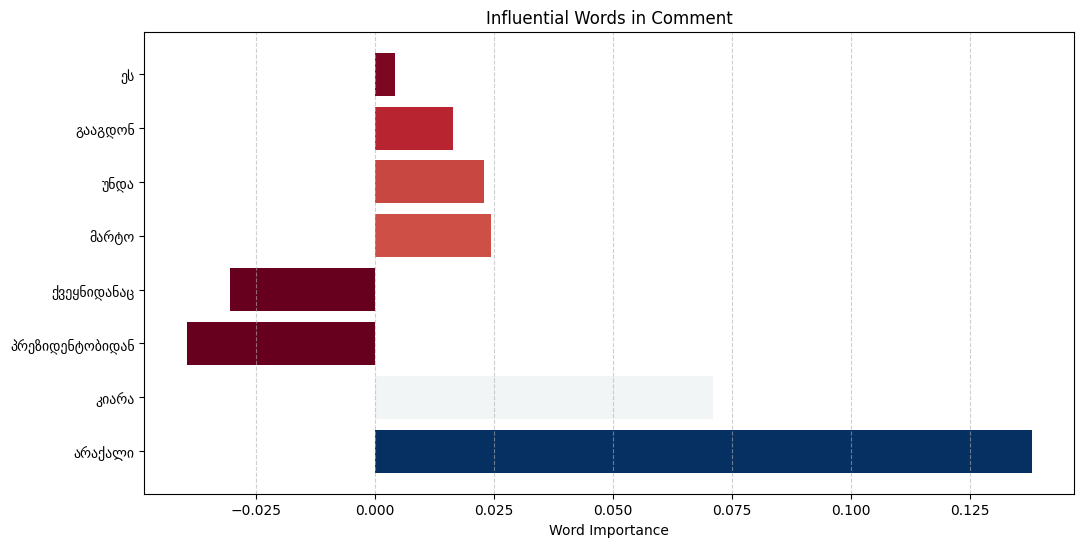

('ეს არაქალი მარტო პრეზიდენტობიდან კიარა ქვეყნიდანაც უნდა გააგდონ', None)

In [210]:
test_inference_results_df.iloc[65]['text'], generate_visual_explanation(test_inference_results_df.iloc[65]['text'], pipeline, 20)

Intercept 0.35748656053972544
Prediction_local [0.34150607]
Right: 0.343508418432629


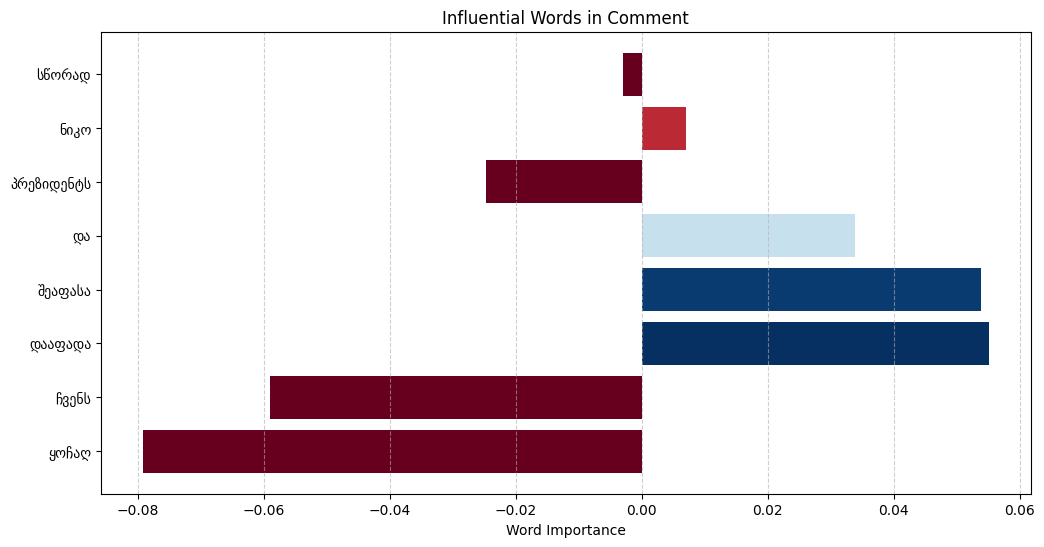

('ყოჩაღ ჩვენს პრეზიდენტს სწორად შეაფასა და დააფადა ნიკო', None)

In [211]:
test_inference_results_df.iloc[141]['text'], generate_visual_explanation(test_inference_results_df.iloc[141]['text'], pipeline, 20)

Intercept 0.3715940182203652
Prediction_local [0.24552492]
Right: 0.2506540084567268


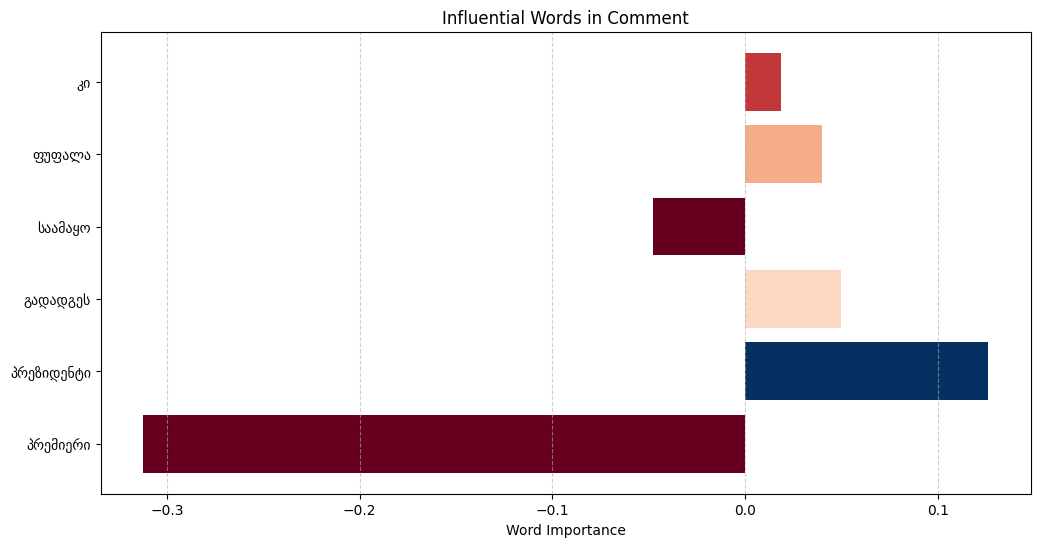

('საამაყო პრემიერი ფუფალა პრეზიდენტი კი გადადგეს', None)

In [212]:
test_inference_results_df.iloc[159]['text'], generate_visual_explanation(test_inference_results_df.iloc[159]['text'], pipeline, 20)

Intercept 0.3082457254651819
Prediction_local [0.08337261]
Right: 0.10065805339912426


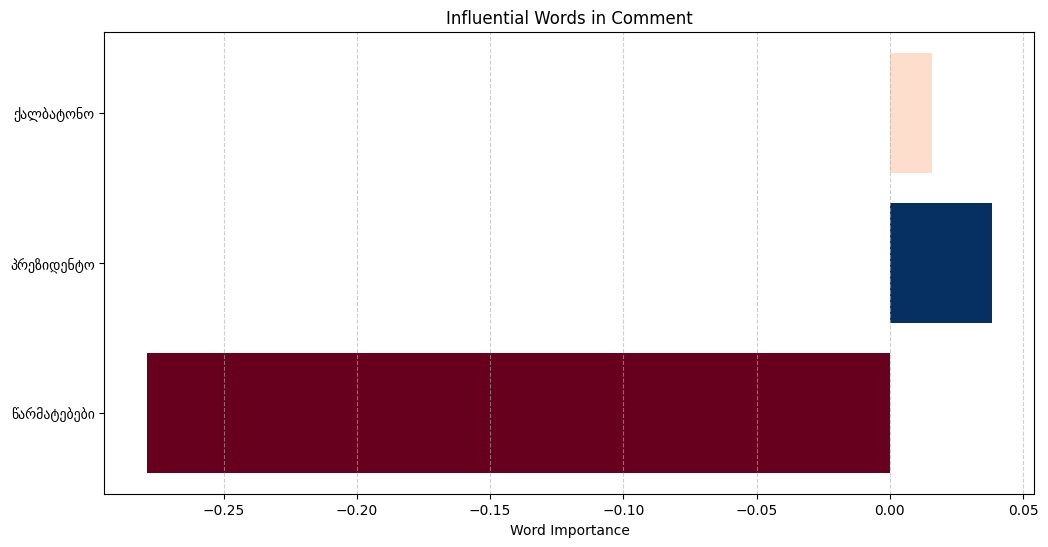

('წარმატებები ქალბატონო პრეზიდენტო', None)

In [213]:
test_inference_results_df.iloc[244]['text'], generate_visual_explanation(test_inference_results_df.iloc[244]['text'], pipeline, 20)

Intercept 0.5106505665090938
Prediction_local [0.7120074]
Right: 0.7053278937989198


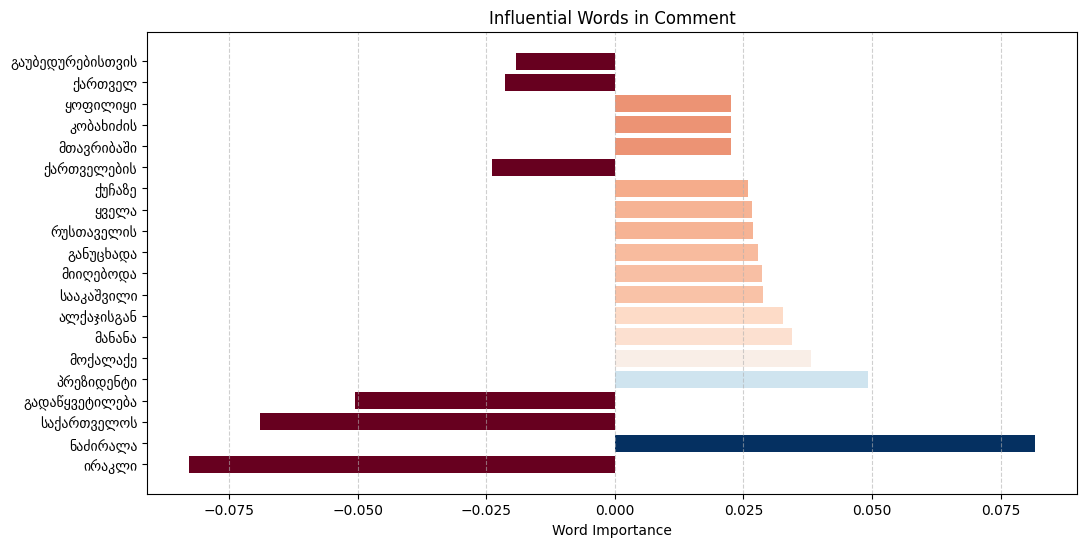

('მანანა კობახიძემ ნაძირალა ხეპრე ირაკლი კობახიძის წიოწკამ განუცხადა ქართველ ემიგრანტებს წელს რომ ექს პრეზიდენტი სააკაშვილი არ არის ღირსი ყოფილიყი საქართველოს მოქალაქე მაგ მონა ალქაჯისგან ელოდით რომ კეთილ სინდისიერი გადაწყვეტილება მიიღებოდა ყველა ქოცი მთავრიბაში რუსთაველის ქუჩაზე უნდა გატუსაღდეს ქართველების გაუბედურებისთვის',
 None)

In [214]:
test_inference_results_df.iloc[343]['text'], generate_visual_explanation(test_inference_results_df.iloc[343]['text'], pipeline, 20)

Intercept 0.6199000511032142
Prediction_local [0.87962809]
Right: 0.8618063215035635


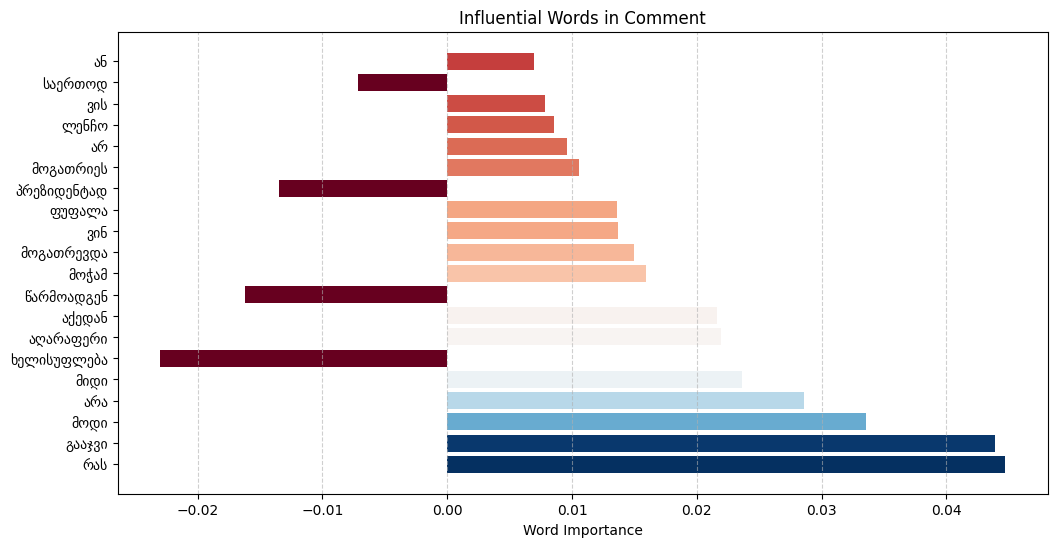

('ეს ქვეყანა თუ არ მოგწონს რომ აღარაფერი გიკვირს გააჯვი აქედან ძალით მოგათრიეს აქ ეს ხელისუფლება რომ არა ვინ მოგათრევდა პრეზიდენტად გინდ მიდი გინდ მოდი რას წარმოადგენ საერთოდ ან ვის რას მოჭამ ლენჩო ფუფალა',
 None)

In [215]:
test_inference_results_df.iloc[416]['text'], generate_visual_explanation(test_inference_results_df.iloc[416]['text'], pipeline, 20)

## Comments About Premier Minister

In [216]:
_premier_samples = test_inference_results_df[test_inference_results_df.text.apply(lambda x: 'პრემიერ' in x)]

In [217]:
_premier_samples.label.value_counts()

0.0    77
1.0     1
Name: label, dtype: int64

In [218]:
_premier_samples

,text,label,predicted_label,hate_prob,non_hate_prob
2,წარმატებები ბატონო პრემიერო,0.0,0.0,0.002444,0.997556
3,წარმატებები უჭკვიანეს და სამშობლოს მოყვარულ პრ...,0.0,0.0,0.050622,0.949378
9,საამაყო პრემიერი,0.0,0.0,0.036282,0.963718
11,წარმატებები ჩვენს საამაყო პრემიერს საუკეთესო გ...,0.0,0.0,0.019490,0.980510
21,წარმატებებიბატონო პრემიერო,0.0,0.0,0.003452,0.996548
...,...,...,...,...,...
397,ბრავო პრემიერო,0.0,0.0,0.009739,0.990261
405,წარმატებები ჩვენს პრემიერს თავისი გუნდით უფალმ...,0.0,0.0,0.062757,0.937243
408,ჩვენო პრემიერ მინისტრო ბევრ ქვეყნებს და შინაურ...,1.0,0.0,0.392911,0.607089
418,წარმატებები ღირსეულო პრემიერო ჩვენი ქვეყნის წი...,0.0,0.0,0.017485,0.982515


Intercept 0.3780240188161899
Prediction_local [0.39271121]
Right: 0.39291085268855436


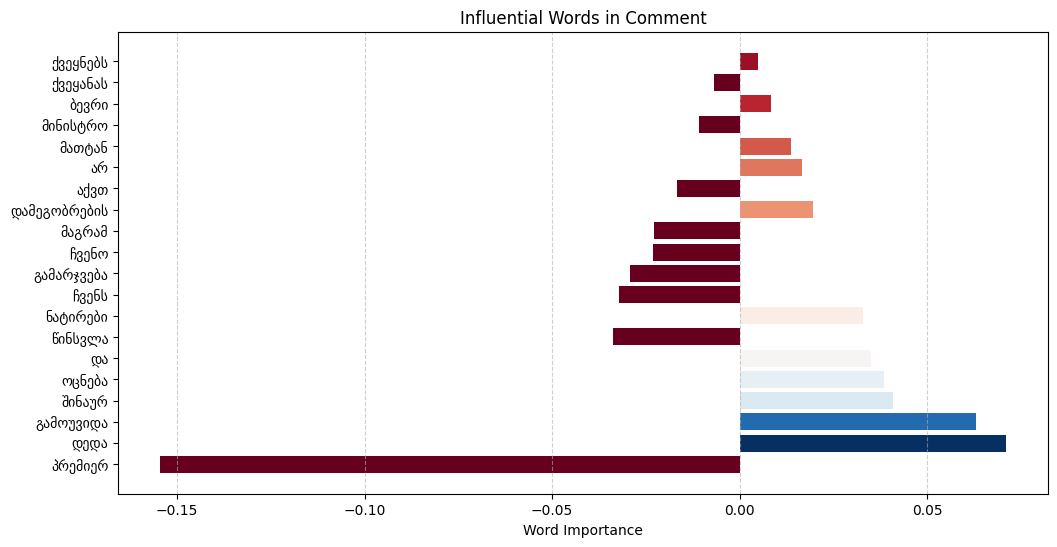

('ჩვენო პრემიერ მინისტრო ბევრ ქვეყნებს და შინაურ მტრებს დედა აქვთ ნატირები ბევრი ქვეყნების ოცნება იყო მათტან დამეგობრების მაგრამ არ გამოუვიდა წინსვლა და გამარჯვება ჩვენს ქვეყანას',
 None)

In [219]:
test_inference_results_df.iloc[408]['text'], generate_visual_explanation(test_inference_results_df.iloc[408]['text'], pipeline, 20)

Intercept 0.21365811207984425
Prediction_local [0.05190319]
Right: 0.06275686778371069


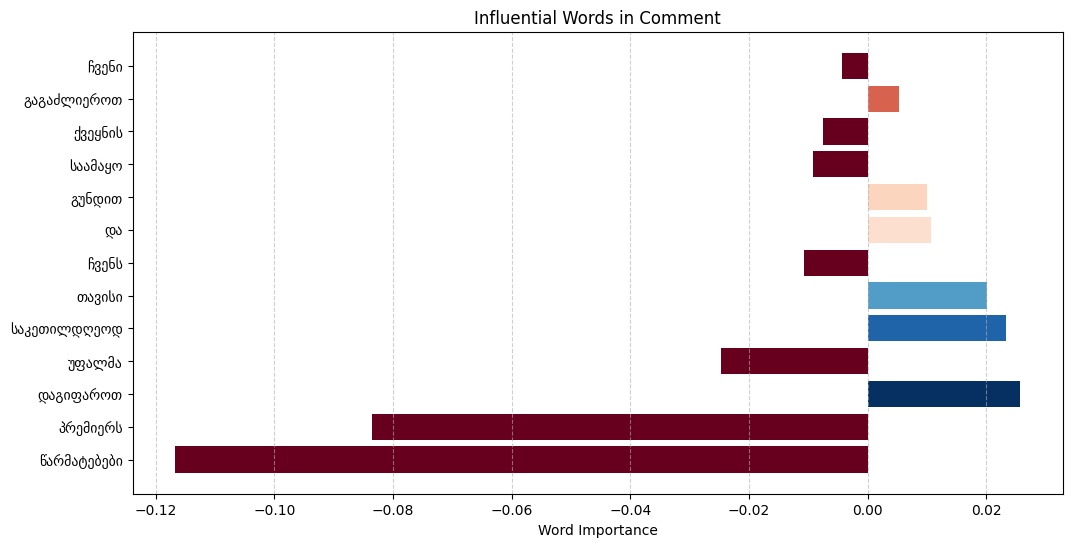

('წარმატებები ჩვენს პრემიერს თავისი გუნდით უფალმა გაგაძლიეროთ და დაგიფაროთ ჩვენი საამაყო ქვეყნის საკეთილდღეოდ',
 None)

In [220]:
test_inference_results_df.iloc[405]['text'], generate_visual_explanation(test_inference_results_df.iloc[405]['text'], pipeline, 20)

# Store Trained Model For Inference

In [221]:
!pip install joblib

In [222]:
import joblib

In [223]:
joblib.dump(pipeline, 'tfidf_logreg_classifier_v2.pkl')

['tfidf_logreg_classifier_v2.pkl']